In [9]:
#Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.providers.aer.noise import NoiseModel, pauli_error
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer, AerSimulator
from random import random

#python imports
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np

plt.style.use("ggplot")

Text(0, 0.5, '10 x (1-f)')

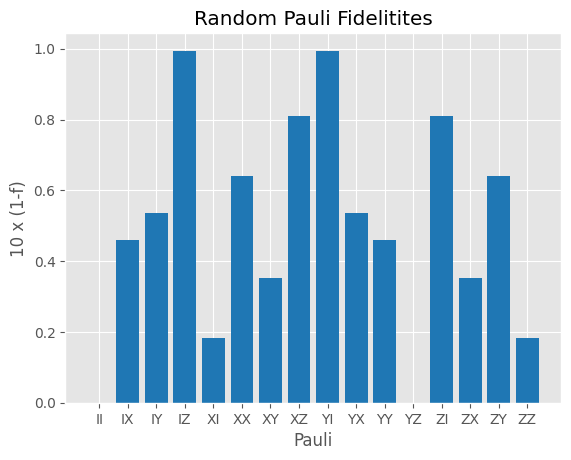

In [10]:
num = 4  #number of errors
errorops = choices(pauli_basis(2), k=num) #choose random pauli errors
errorprobs = [random()*.1/num for op in errorops] #assign random probabilities
#create normalized error model
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data #Find out more about this
for i,pauli in enumerate(pauli_basis(2)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real, color="tab:blue")

plt.title("Random Pauli Fidelitites")
plt.xlabel("Pauli")
plt.ylabel("10 x (1-f)")